Time Series analysis of IQFeed 5 Sec data of SPY

In [1]:
import pandas as pd
import numpy as np
import urllib2
import urllib
import datetime
import datetime as dt
from datetime import datetime
from pytz import timezone
import pytz
from time import gmtime, strftime
import time
import os
from random import randint
import math
import seaborn
from matplotlib import interactive
interactive(False)
from pylab import rcParams
from pandas_datareader import data as web
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [3]:
#to download data from IQFeed
#%run iqfeed_download.py

In [4]:
path = '/home/octo/Desktop/PROJECT_1/IQ_data/'

In [5]:
SPY=pd.read_csv(path + 'SPY.csv',names = ["high", "low", "open","close","total_volume","volume"],index_col=0, parse_dates=True)

In [6]:
SPY.dtypes

high            float64
low             float64
open            float64
close           float64
total_volume      int64
volume            int64
dtype: object

In [7]:
SPY.isnull().any()

high            False
low             False
open            False
close           False
total_volume    False
volume          False
dtype: bool

In [80]:
ret = (SPY['open']/SPY['close'].shift(1))-1
ret=ret.dropna()

In [81]:
ret.isnull().any()

False

In [82]:
#https://pypi.python.org/pypi/arch/3.0
### Unit Root Tests
from arch import arch_model
am = arch_model(ret)
res = am.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: -835158.137044
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -835158.136933
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1


/home/octo/anaconda2/envs/PyAlgo/lib/python2.7/site-packages/arch/univariate/base.py:510: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [51]:
# Function to compute parameters
def sharpe_ratio(x):
    mu, sigma = 12 * x.mean(), np.sqrt(12 * x.var())
    return np.array([mu, sigma, mu / sigma])

# Bootstrap confidence intervals
from arch.bootstrap import IIDBootstrap
bs = IIDBootstrap(ret)
ci = bs.conf_int(sharpe_ratio, 1000, method='percentile')

### Multiple Comparison Procedures

In [73]:
SPY.C=SPY.close
SPY.O=SPY.open

In [74]:
SPY.C.tail()

2016-08-08 15:59:40    218.035
2016-08-08 15:59:45    218.030
2016-08-08 15:59:50    218.010
2016-08-08 15:59:55    218.010
2016-08-08 16:00:00    218.030
Name: close, dtype: float64

In [75]:
SPY.C.dtype

dtype('float64')

In [173]:
len(SPY.C)

8807

In [193]:
# make a trended sine wave
SPY['wave'] = [10 * math.sin(i * 2 * math.pi / 25) + i * i /100.0 for i in range(8807)]
s = [10 * math.sin(i * 2 * math.pi / 25) + i * i /100.0 for i in range(8807)]

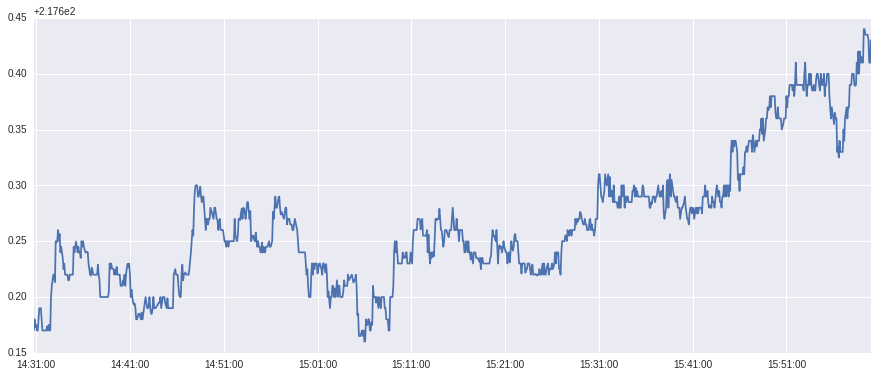

In [182]:
plt.plot(SPY.C.tail(1000))

Function for testing stationarity

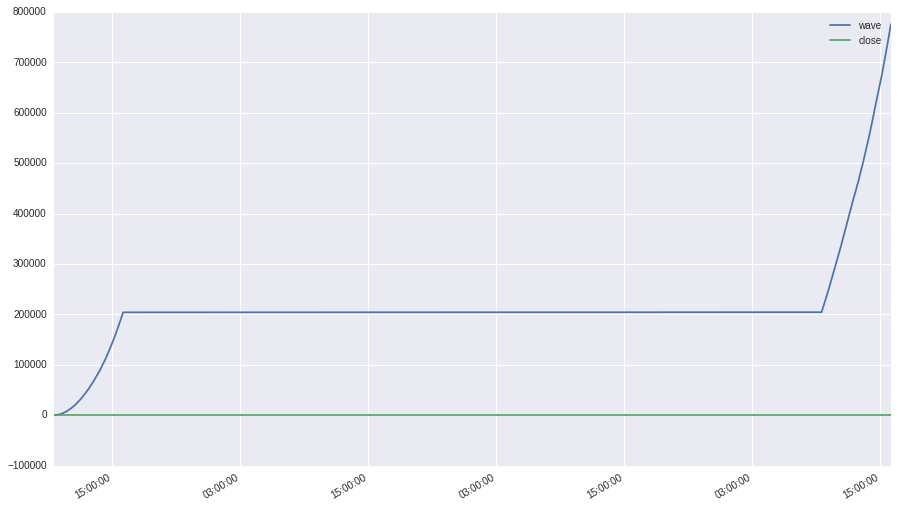

In [188]:
SPY[['wave','close']].plot(figsize=(15, 9));

In [33]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

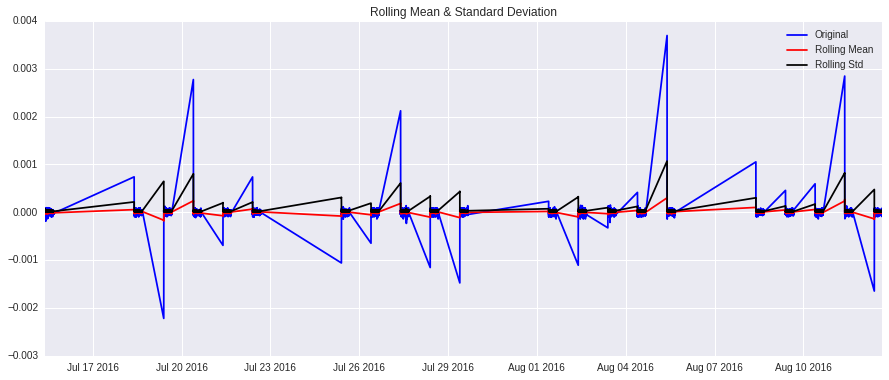

Results of Dickey-Fuller Test:
Test Statistic                  -217.231546
p-value                            0.000000
#Lags Used                         1.000000
Number of Observations Used    94620.000000
Critical Value (5%)               -2.861571
Critical Value (1%)               -3.430419
Critical Value (10%)              -2.566786
dtype: float64


In [55]:
test_stationarity(ret)

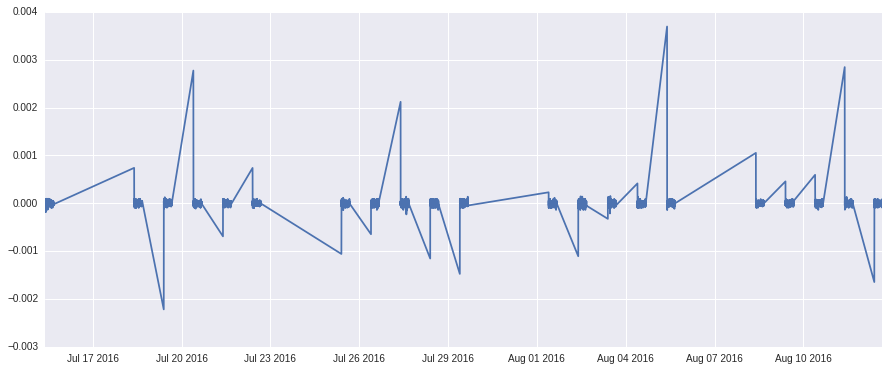

In [56]:
plt.plot(ret)

Estimating & Eliminating Trend

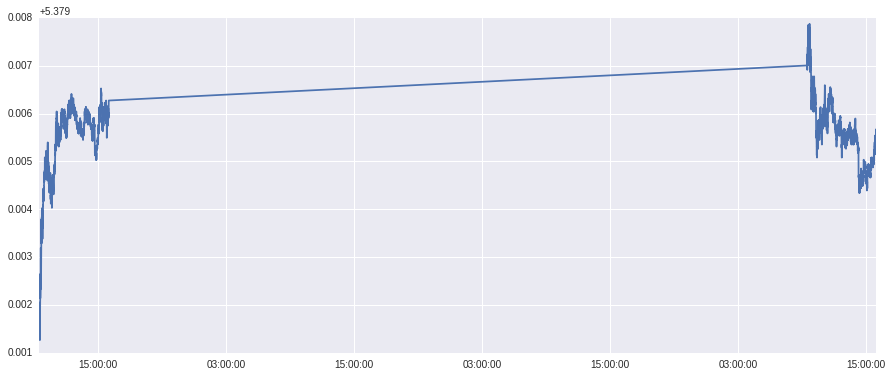

In [79]:
ts_log = np.log(SPY.C)
plt.plot(ts_log)

Smoothing:

Moving average

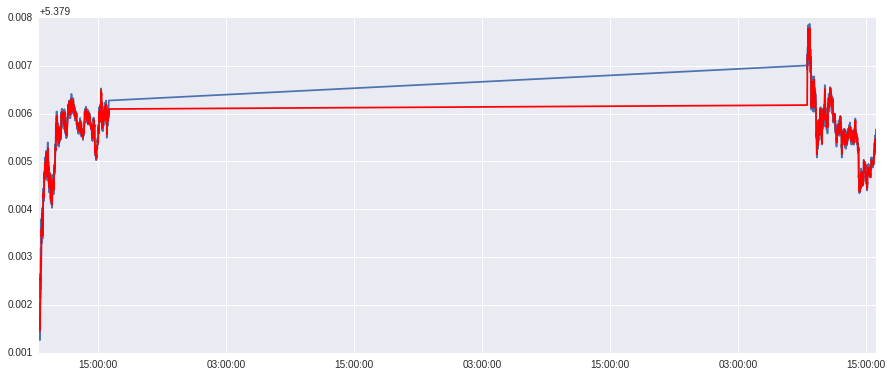

In [80]:
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [81]:
ts_log_moving_avg_diff = ts_log - moving_avg

In [82]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head()

2016-08-05 09:31:00    0.000217
2016-08-05 09:31:05   -0.000155
2016-08-05 09:31:10    0.000118
2016-08-05 09:31:15    0.000102
2016-08-05 09:31:20    0.000014
Name: close, dtype: float64

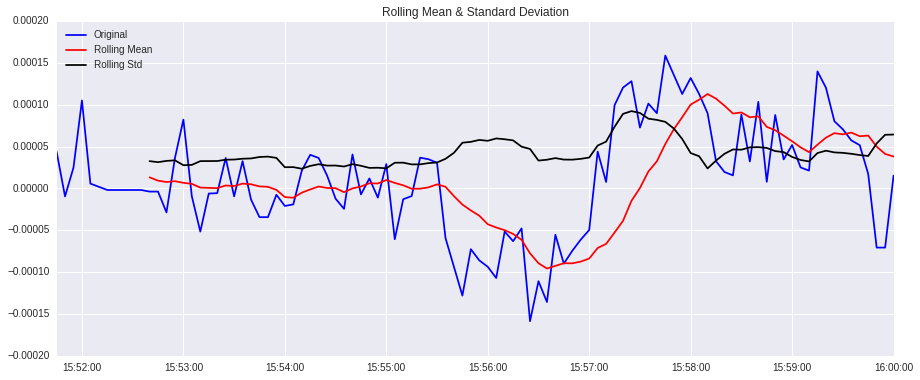

Results of Dickey-Fuller Test:
Test Statistic                 -2.161145
p-value                         0.220649
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (5%)            -2.892152
Critical Value (1%)            -3.500379
Critical Value (10%)           -2.583100
dtype: float64


In [83]:
test_stationarity(ts_log_moving_avg_diff.tail(100))

Exponentially Weighted Moving Average

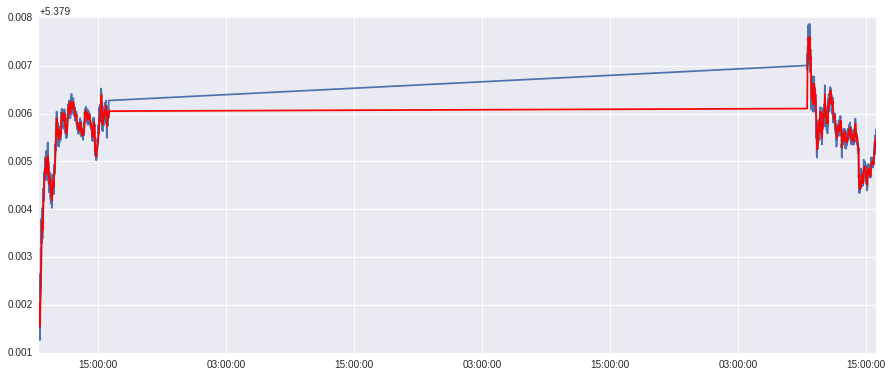

In [84]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
# expwighted_avg.plot(style='k--')

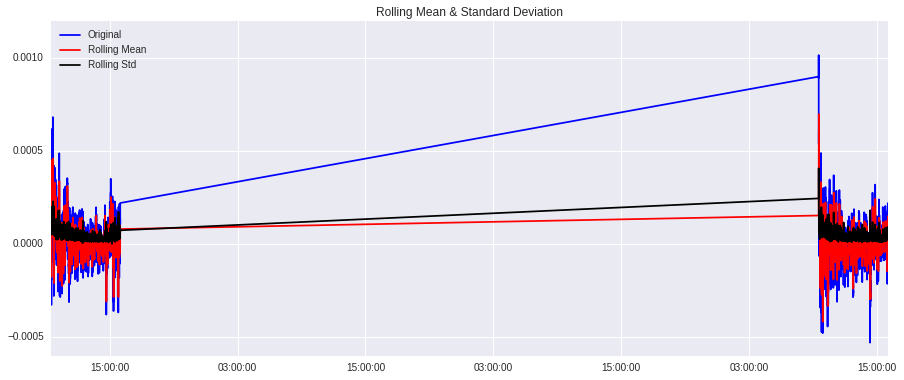

Results of Dickey-Fuller Test:
Test Statistic                -1.645683e+01
p-value                        2.350199e-29
#Lags Used                     3.000000e+00
Number of Observations Used    8.803000e+03
Critical Value (5%)           -2.861868e+00
Critical Value (1%)           -3.431093e+00
Critical Value (10%)          -2.566945e+00
dtype: float64


In [85]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

Eliminating Trend and Seasonality

Differencing:

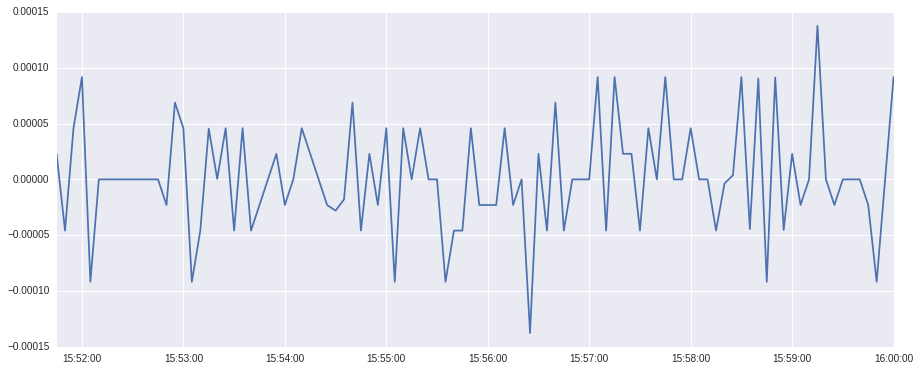

In [86]:
#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff.tail(100))

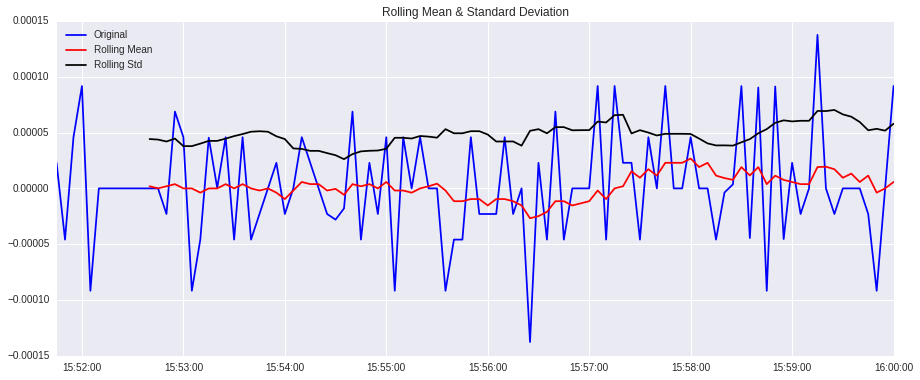

Results of Dickey-Fuller Test:
Test Statistic                -7.448731e+00
p-value                        5.745471e-11
#Lags Used                     2.000000e+00
Number of Observations Used    9.700000e+01
Critical Value (5%)           -2.891831e+00
Critical Value (1%)           -3.499637e+00
Critical Value (10%)          -2.582928e+00
dtype: float64


In [87]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff.tail(100))

Decomposition:

In [88]:
#ts_log = np.log(SPY[['close']])

In [89]:
ts_log.index

DatetimeIndex(['2016-08-05 09:30:05', '2016-08-05 09:30:10',
               '2016-08-05 09:30:15', '2016-08-05 09:30:20',
               '2016-08-05 09:30:25', '2016-08-05 09:30:30',
               '2016-08-05 09:30:35', '2016-08-05 09:30:40',
               '2016-08-05 09:30:45', '2016-08-05 09:30:50',
               ...
               '2016-08-08 15:59:15', '2016-08-08 15:59:20',
               '2016-08-08 15:59:25', '2016-08-08 15:59:30',
               '2016-08-08 15:59:35', '2016-08-08 15:59:40',
               '2016-08-08 15:59:45', '2016-08-08 15:59:50',
               '2016-08-08 15:59:55', '2016-08-08 16:00:00'],
              dtype='datetime64[ns]', length=8807, freq=None)

In [90]:
#ts_log['2016-08'].tail()

In [91]:
#ts = ts_log['close'] 
#ts.head(10)

In [92]:
#ts.tail()

In [93]:
#pd.Series(ts_log)

In [94]:
#from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm 

In [95]:
#decompfreq = 390*60/5*4

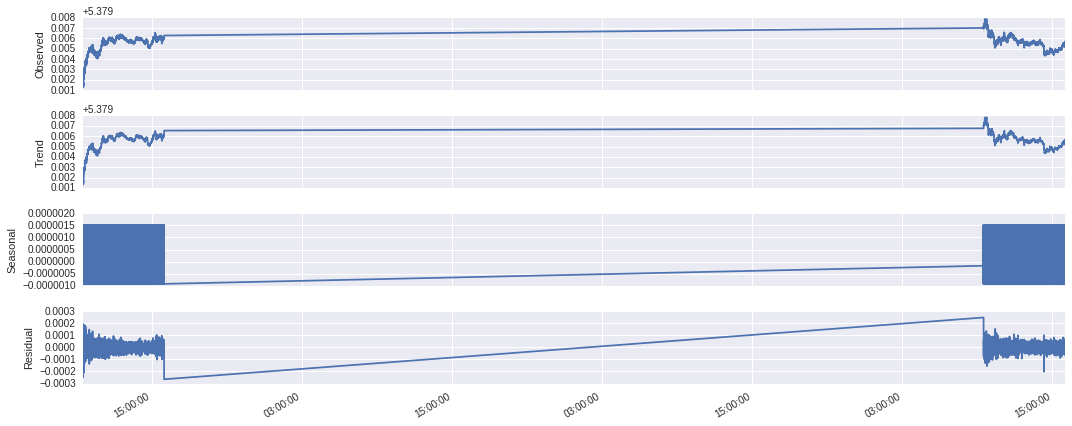

In [96]:
res = sm.tsa.seasonal_decompose(ts_log,freq=5,model='additive')
resplot = res.plot()
resplot.savefig('Seasonal_Decompose.png', dpi=150)

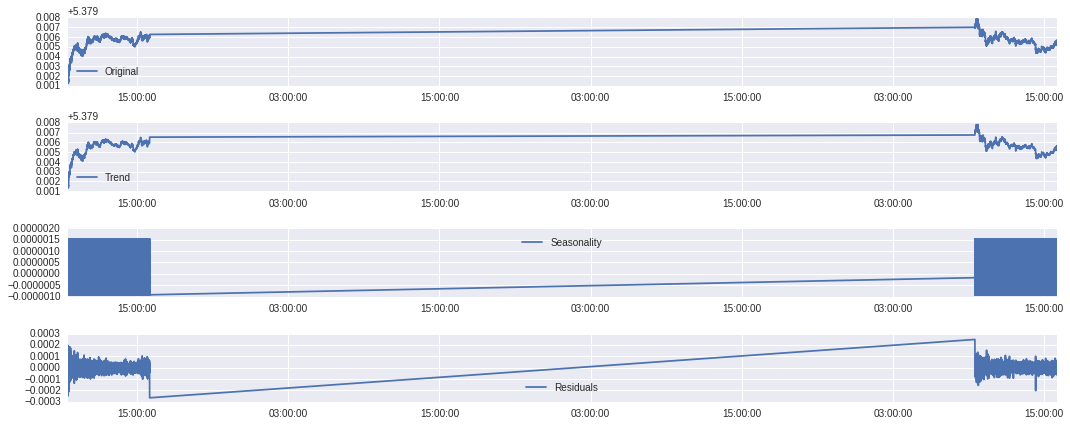

In [97]:
decomposition = res

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [98]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

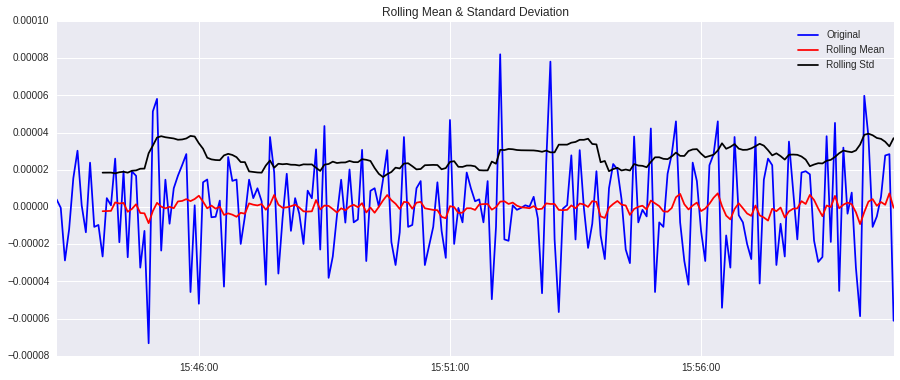

Results of Dickey-Fuller Test:
Test Statistic                -8.585251e+00
p-value                        7.537867e-14
#Lags Used                     6.000000e+00
Number of Observations Used    1.930000e+02
Critical Value (5%)           -2.876635e+00
Critical Value (1%)           -3.464694e+00
Critical Value (10%)          -2.574816e+00
dtype: float64


In [99]:
test_stationarity(ts_log_decompose.tail(200))

Forecasting a Time Series

In [100]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [101]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

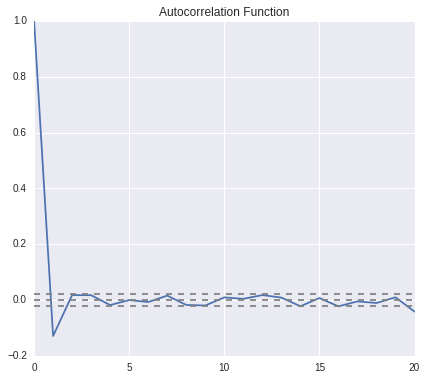

In [102]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

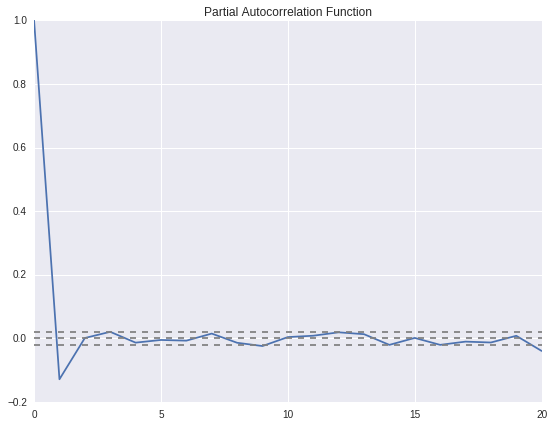

In [103]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [104]:
from statsmodels.tsa.arima_model import ARIMA

AR Model

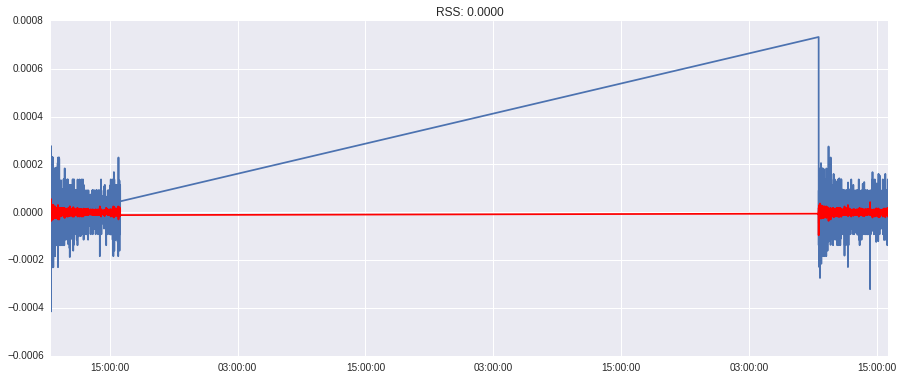

In [105]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

MA Model

/home/octo/anaconda2/envs/PyAlgo/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


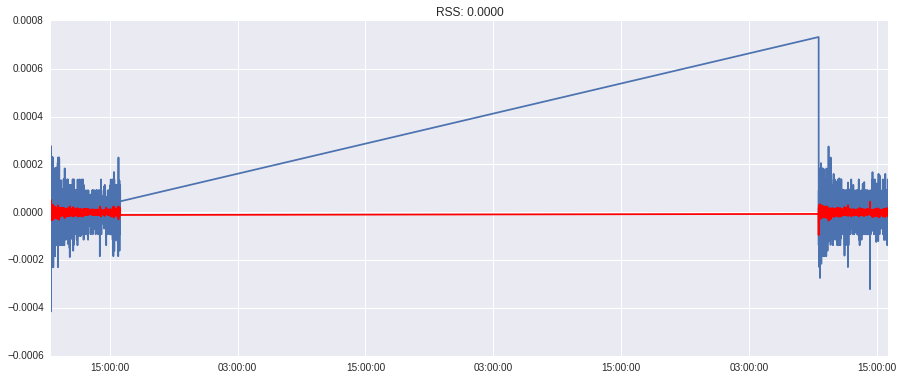

In [106]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

Combined Model

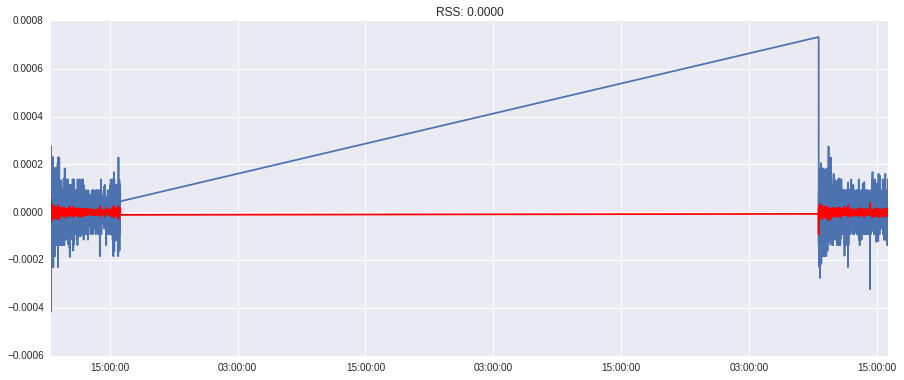

In [108]:
model = ARIMA(ts_log, order=(2, 1, 3))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

Taking it back to original scale

In [109]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

2016-08-05 09:30:10    4.045404e-07
2016-08-05 09:30:15    3.556585e-05
2016-08-05 09:30:20    1.792645e-05
2016-08-05 09:30:25   -1.901720e-05
2016-08-05 09:30:30    1.535328e-05
dtype: float64


In [110]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

2016-08-05 09:30:10    4.045404e-07
2016-08-05 09:30:15    3.597039e-05
2016-08-05 09:30:20    5.389684e-05
2016-08-05 09:30:25    3.487964e-05
2016-08-05 09:30:30    5.023292e-05
dtype: float64


In [111]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

2016-08-05 09:30:05    5.381049
2016-08-05 09:30:10    5.381049
2016-08-05 09:30:15    5.381085
2016-08-05 09:30:20    5.381103
2016-08-05 09:30:25    5.381084
dtype: float64

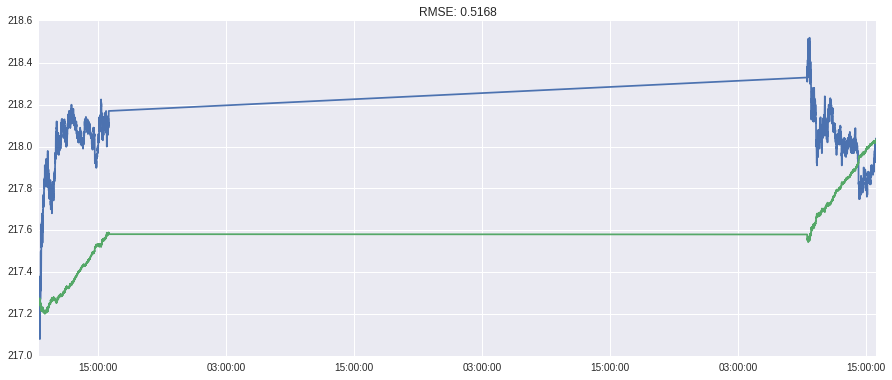

In [112]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(SPY.C)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-SPY.C)**2)/len(SPY.C)))

MANN KENDALL test
http://vsp.pnnl.gov/help/Vsample/Design_Trend_Mann_Kendall.htm

http://pydoc.net/Python/ambhas/0.4.0/ambhas.stats/


In [157]:
from __future__ import division
import numpy as np
from scipy.stats import norm, mstats

In [158]:
def mk_test(x, alpha = 0.05):
    """
    This function is derived from code originally posted by Sat Kumar Tomer (satkumartomer@gmail.com)
    See also: http://vsp.pnnl.gov/help/Vsample/Design_Trend_Mann_Kendall.htm
    
    The purpose of the Mann-Kendall (MK) test (Mann 1945, Kendall 1975, Gilbert 1987) is to statistically assess if there is a monotonic upward or downward trend of the variable of interest over time. A monotonic upward (downward) trend means that the variable consistently increases (decreases) through time, but the trend may or may not be linear. The MK test can be used in place of a parametric linear regression analysis, which can be used to test if the slope of the estimated linear regression line is different from zero. The regression analysis requires that the residuals from the fitted regression line be normally distributed; an assumption not required by the MK test, that is, the MK test is a non-parametric (distribution-free) test.
    Hirsch, Slack and Smith (1982, page 107) indicate that the MK test is best viewed as an exploratory analysis and is most appropriately used to identify stations where changes are significant or of large magnitude and to quantify these findings.
    
    Input:
        x:   a vector of data
        alpha: significance level (0.05 default)
    
    Output:
        trend: tells the trend (increasing, decreasing or no trend)
        h: True (if trend is present) or False (if trend is absence)
        p: p value of the significance test
        z: normalized test statistics 
        
    Examples
    --------
      >>> x = np.random.rand(100)
      >>> trend,h,p,z = mk_test(x,0.05) 
    """
    n = len(x)
    
    # calculate S 
    s = 0
    for k in range(n-1):
        for j in range(k+1,n):
            s += np.sign(x[j] - x[k])
    
    # calculate the unique data
    unique_x = np.unique(x)
    g = len(unique_x)
    
    # calculate the var(s)
    if n == g: # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
    else: # there are some ties in data
        tp = np.zeros(unique_x.shape)
        for i in range(len(unique_x)):
            tp[i] = sum(unique_x[i] == x)
        var_s = (n*(n-1)*(2*n+5) + np.sum(tp*(tp-1)*(2*tp+5)))/18
    
    if s>0:
        z = (s - 1)/np.sqrt(var_s)
    elif s == 0:
            z = 0
    elif s<0:
        z = (s + 1)/np.sqrt(var_s)
    
    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z))) # two tail test
    h = abs(z) > norm.ppf(1-alpha/2) 
    
    if (z<0) and h:
        trend = 'decreasing'
    elif (z>0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'
        
    return trend, h, p, z

In [163]:
trend.dropna().tail()

2016-08-08 15:59:30    5.384660
2016-08-08 15:59:35    5.384651
2016-08-08 15:59:40    5.384628
2016-08-08 15:59:45    5.384605
2016-08-08 15:59:50    5.384601
Name: close, dtype: float64

In [165]:
trend =np.unique(trend.dropna()) 
test_trend,h,p,z = mk_test(trend,alpha=0.05)  
print test_trend, h  
print z, p  

increasing True
42.1472233364 0.0


http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html#scipy.stats.kendalltau

pip install seasonal# already installed

https://github.com/welch/seasonal